In [8]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Load the datasets
errors =  pd.read_csv('data/PdM_errors.csv')
failures =  pd.read_csv('data/PdM_failures.csv')
machines =  pd.read_csv('data/PdM_machines.csv')
maint =  pd.read_csv('data/PdM_maint.csv')
telemetry =  pd.read_csv('data/PdM_telemetry.csv')

In [18]:
# Change datetime strings to real datetimes
errors['datetime'] = pd.to_datetime(errors['datetime'])
failures['datetime'] = pd.to_datetime(failures['datetime'])
maint['datetime'] = pd.to_datetime(maint['datetime'])
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,error1
1,2015-01-03 20:00:00,1,error3
2,2015-01-04 06:00:00,1,error5
3,2015-01-10 15:00:00,1,error4
4,2015-01-22 10:00:00,1,error4


([<matplotlib.axis.XTick at 0x1b225af3580>,
 [Text(0, 0, 'error1'),
  Text(1, 0, 'error2'),
  Text(2, 0, 'error3'),
  Text(3, 0, 'error4'),
  Text(4, 0, 'error5')])

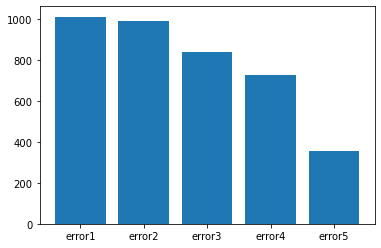

In [53]:
'''e = errors.groupby('errorID').count()
plt.bar(np.arange(len(e.index)), e.machineID)
plt.xticks(np.arange(len(e.index)), labels=e.index)'''
